Chris Ventura<br>
Final Project<br>
Final Notebook<br>

Goal: <br>
    <BLOCKQUOTE> To determine if a Medicare Advantage Health Plan's Medical Loss Ratio (MLR) can be predicted using publicly available information specific to the health plan (risk score, average monthly payment, county breakdown, STARS quality scores, plan type) and competitive market (market average risk score, market average monthly payment, market average payment rate).</BLOCKQUOTE>

Background: <br>
        <BLOCKQUOTE>MLR is a health plan's total health expenditure divided by a health plan's total premium revenue. This metric is typically how health plans determine profitability, and even how the government regulates markets (typically plans must spend at least 85% of their premium revenue on health delivery or improvement, or have an MLR of at least 0.85). Typically, health plans would like their MLR to be as close to .85 as possible, but as a rule of thumb, lower is better. </BLOCKQUOTE>
        
Project Approach: <br>
        <BLOCKQUOTE>For my project, I attempt to determine the impact of market and population on a health plan's MLR. To do so, I use several publicly available files. I use a plan's product and county membership makeup to aggregate all stats to the plan level, as seen in Section 2. I then use the plan level data to try to estimate a plan's MLR using Linear Regression.  After Linear Regression proves somewhat not predictive, I transform MLR into a binary variable, is_profitable, indicating whether of not the plan is profitable.  I then have much more predictive results using Random Forest and Logistic Regression classifiers.</BLOCKQUOTE>
        
Feature Selection: <br>
        <BLOCKQUOTE>As shown in Section 3, I examined correlations between possible features and my outcome variable.  Although Section 4 contains my final models with selected features, I ran through several iterations of each model trying different combinations of features.  Because certain features are tightly correlated (such as plan risk score and market risk score, as seen at the end of Section 3), I ran through the model with different iterations of these variables, and ultimately settled on using only plan characteristics for these values, as those proved more predictive and I wanted to avoid multicollinearity bias.  I ultimately chose plan risk score, plan average payment, market penetration rate, plan STARS score (used as dummy variables to include N/A values which indicate new plans), organization type (National, Regional, Blue), and network type (HMO, PPO, etc.) as my features.</BLOCKQUOTE>
        
Modeling, Interpretation, and Conclusion: <br>
        <BLOCKQUOTE>Section 4 illustrates the performance of my features in a Linear Regression, Random Forest, and Logistic Regression.  As shown in the performance statistics, the Random Forest and Logistic Regressions perform better.  I interpret this as follow: while profitable plans share similar characteristics, the relationships are not all that linear.  While profitable plans tend to be national carriers, HMOs, have higher risk scores, and provide service in markets with more penetration, this is not true in all cases.
        <br>
        <br>
                    Given this and the results of my feature selection exercise, I conclude that market characteristics do influence plan performance, but the plan's own characteristics have a more significant impact on plan MLR.  While high-performing plans tend to have similar characteristics, there are quite a few contradictory examples.  Health plan performance may simply depend on so many factors that precise modeling is difficult, even if specific trends are identifiable.</BLOCKQUOTE>

Additional Insights: <br>
        <BLOCKQUOTE>Although my model did not lead me to a definitive conclusion, I did identify some trends that go against intuition or previous speculation.  For one, market penetration proved to be the market characteristic with the most influence.  It appears that a higher penetration rate is correlated with better plan performances, even though this is often associated with greater market competition.  Perhaps these markets have more ideal consumers for Medicare Advantage plans.  Another interesting insight is that plans with higher quality rating (STARS scores) perform slightly worse, on average, than more plans that are more middle of the road quality-wise.  While the correlation is not incredibly strong, it certainly is an interesting thought exercise to try to determine why that might be, and maybe a future area for research.
        </BLOCKQUOTE>
 
Areas for Future Research: <br>
        <BLOCKQUOTE>Although I only had one year's worth of data to use, CMS is expected to release 2015 data shortly.  It would be very interesting to incorporate this data and see any additional impact, or if a greater sample size would allow for the creation of a stronger model.  It would also be interesting to incorporate additional county demographic data to see if I can tease out any more significant market impact.</BLOCKQUOTE>
        <br>
        <br>
Finally, as part of my presentation I created several maps and a nice dataframe containing county-level geojson information.  Trying to load my maps in Jupyter crashed Jupyter, so I have included those maps in the GitHub repository along with my presendation. I have the code below, but I put it in a markdown so it is not accidently run.

Section 0 - Import Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import plotly 
plotly.tools.set_credentials_file(username='cventura', api_key='pVVqB9wlkboP20bpNAe6')

from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

Section 1 - Import Various Datasets for analysis to create master dataset

In [3]:
# 1.1 - Plan Level MLR data (note, this is going to be my hub)
# Note - I heavily edited this in excel to remove unnecessary columns (there were like 200)
df_MLR = pd.read_csv("/Users/cventura/GitHub/final_project/final_datasets/Clean_2014_Plan_MLR.csv")
print df_MLR.head()
# The contract number (commonly referred to as H code) will be how I join all datasets

# 1.2 - Plan Level Risk Score
df_PlanPartCRS = pd.read_csv("/Users/cventura/GitHub/final_project/final_datasets/Clean_2014_Plan_PartC_RS.csv")
print df_PlanPartCRS.head()

# 1.3 - County Level Risk Score
df_CountyPartCRS = pd.read_csv("/Users/cventura/GitHub/final_project/final_datasets/Clean_2014_County_PartC_RS.csv", dtype={'county_code': np.str})
print df_CountyPartCRS.head()

# 1.4 - Contract Info
df_ContractInfo = pd.read_csv("/Users/cventura/GitHub/final_project/final_datasets/CPSC_Contract_Info_2014_12.csv")
print df_ContractInfo.head(50)

# 1.5 - County Plan Enrollment Info
df_CountyPlanEnrollmentInfo = pd.read_csv("/Users/cventura/GitHub/final_project/final_datasets/CPSC_Enrollment_Info_2014_12.csv", dtype={'SSA State County Code': np.str})
df_CountyPlanEnrollmentInfo = df_CountyPlanEnrollmentInfo[df_CountyPlanEnrollmentInfo.Enrollment != '*']
df_CountyPlanEnrollmentInfo = df_CountyPlanEnrollmentInfo[df_CountyPlanEnrollmentInfo['Plan ID'] != 999]
print len(df_CountyPlanEnrollmentInfo)

# 1.6 - Plan Enrollment Info
df_PlanEnrollmentInfo = pd.read_csv("/Users/cventura/GitHub/final_project/final_datasets/Monthly_Report_By_Plan_2014_12.csv")
print df_PlanEnrollmentInfo.head(50)

# 1.7 - State/County Penetration Rates
df_countypen = pd.read_csv("/Users/cventura/GitHub/final_project/final_datasets/State_County_Penetration_MA_2014_12.csv", dtype={'SSA': np.str, 'FIPSST': np.str, 'FIPSCNTY':np.str})
df_countypen['Penetration'].fillna(value=0.00, inplace = True)
print df_countypen.head(100)

# 1.8 - Plan PBP Detailed Info
df_planPBPInfo = pd.read_csv("/Users/cventura/GitHub/final_project/final_datasets/CPSC_Contract_Info_2014_12.csv")
df_planPBPInfo = df_planPBPInfo.dropna()
print df_planPBPInfo.head()

# 1.9 - Part C Stars
df_stars = pd.read_csv("/Users/cventura/GitHub/final_project/final_datasets/Part_C_Stars.csv")
print df_stars.head()
#Note - Lot of NA's in the actual STARS scores - this is expected, as CMS often does not have
# enough data to score, especially for new members

  contract_number  contract_year  \
0           H0028           2014   
1           H0084           2014   
2           H0104           2014   
3           H0107           2014   
4           H0108           2014   

                                       organization  adjusted_MLR  
0                                      CHA HMO INC.          0.96  
1  CARE IMPROVEMENT PLUS OF TEXAS INSURANCE COMPANY          0.96  
2                 Blue Cross Blue Shield of Alabama          0.92  
3                   Health Care Service Corporation          1.02  
4             HUMANA HEALTH PLAN OF CALIFORNIA INC.          0.99  
  contract_number  plan_benefit_package contract_name plan_type  \
0           H0028                     1  CHA HMO INC.       HMO   
1           H0028                     2  CHA HMO INC.       HMO   
2           H0028                     3  CHA HMO INC.       HMO   
3           H0028                     4  CHA HMO INC.       HMO   
4           H0028                     5 

Couple Notes:
1. As stated above, the MLR table will serve as my hub.  The grain of this dataframe is one record per MCO Contract Number (also referred to as an "H Code" due to the first character of the field).
2. Most of the files are at either a county level or a Plan Benefit Package (PBP) level.  A PBP is a variant of the product offered by the health plan.  One H Code may have multiple PBPs, but each PBP can only have on H Code.  Typically these products are very similar, but may have small differences, such as the type of drug coverage offered.
3. The County Plan Enrollment table contains enrollment in each PBP by county.  I strip out records where the enrollment is a star (less than 10 enrolled, which means they cannot give the exact number due to some weird HIPAA bylaw) or where the PBP number is "999", which is a catch-all for incomplete information.  I will use this table in the coming steps to determine the percent of a plan's enrollment in each PBP and in each county to come up with weighted averages for risk scores, payment rates, etc.

Section 2 - Adjust data to same grain

Note: <br>
A couple of my joins cause some records from the original MLR table to fall out.  This is intentional - I validated that the records that drop are from specific types of plans whose information is not reported in the other files, and are not comparable to the other plans which we are analyzing.

In [4]:
#2.1 - Create PBP and County Tables

#   2.1.1 - Remove Counties with no enrollment and append SNP info
    #Convert Enrollment to Numeric
df_CountyPlanEnrollmentInfo['Enrollment'] = df_CountyPlanEnrollmentInfo['Enrollment'].apply(pd.to_numeric)
    #Convert Plan_ID to Int
df_planPBPInfo['Plan ID'] = df_planPBPInfo['Plan ID'].astype(int)
    #Add additional is_SNP field.  SNPs(Special Needs Plans) attract a different membership
    #and have a different risk score, I will use this when rolling up the values later
df_planPBPInfo['is_SNP'] = df_planPBPInfo['SNP Plan'].apply(lambda x: 1 if x == 'Yes' else 0)
    #Merge PBP info to county enrollment info
df_CountyPlanEnrollmentInfo = df_CountyPlanEnrollmentInfo.merge(df_planPBPInfo, how= 'left', left_on = ['Contract Number', 'Plan ID'], right_on= ['Contract ID', 'Plan ID'])
    #Calculate SNP-only enrollment
df_CountyPlanEnrollmentInfo['snp_enrollment'] = df_CountyPlanEnrollmentInfo['is_SNP'] * df_CountyPlanEnrollmentInfo['Enrollment']

#   2.1.2 - Count total enrollment by HCode
df_PlanEnrollmentTotal = df_CountyPlanEnrollmentInfo.groupby('Contract Number')['Enrollment'].sum(
        ).reset_index().rename(columns ={'Enrollment': 'total_enrollment'})

#   2.1.3 - Count total enrollment by HCode/PBP and create PBP % of total ratio
df_planPBPTotals = df_CountyPlanEnrollmentInfo.groupby(['Contract Number', 'Plan ID'])['Enrollment'].sum(
        ).reset_index().rename(columns ={'Enrollment': 'pbp_enrollment'})

df_planPBPTotals = df_planPBPTotals.merge(df_PlanEnrollmentTotal, left_on= 'Contract Number', right_on= 'Contract Number')
    #Create pct ratio of each PBP to plan total - for plan level roll up
df_planPBPTotals['PBP_pct_total'] = df_planPBPTotals['pbp_enrollment'] / df_planPBPTotals['total_enrollment']

#   2.1.4 - Count total enrollment by HCode/county and create county % of total ratio
df_plancountyTotals = df_CountyPlanEnrollmentInfo.groupby(['Contract Number', 'SSA State County Code'])[['Enrollment', 'snp_enrollment']].sum(
        ).reset_index().rename(columns ={'Enrollment': 'county_enrollment', 'SSA State County Code': 'county_code', 'snp_enrollment': 'county_snp_enrollment'})

df_plancountyTotals = df_plancountyTotals.merge(df_PlanEnrollmentTotal, left_on= 'Contract Number', right_on= 'Contract Number')
    #Create county totals and snp percentages
df_plancountyTotals['county_pct_total'] = df_plancountyTotals['county_enrollment'] / df_plancountyTotals['total_enrollment']
df_plancountyTotals['county_snp_pct'] = df_plancountyTotals['county_snp_enrollment'] / df_plancountyTotals['county_enrollment']

#2.2 - Aggregate data to plan level using county/pbp pcts

#   2.2.1 Generate Plan level Risk Scores/Avg Payment and attach to hub
df_planRS_merge = df_PlanPartCRS.merge(df_planPBPTotals, left_on= ['contract_number', 'plan_benefit_package'],\
                                 right_on= ['Contract Number', 'Plan ID'])
    #Multiply risk score and average payments by PBP percentages
df_planRS_merge['RSxPct'] = df_planRS_merge['part_C_risk_score'] * df_planRS_merge['PBP_pct_total']
df_planRS_merge['AvgCPymtxPct'] = df_planRS_merge['average_C_payment'] * df_planRS_merge['PBP_pct_total']
    #Roll up values from previous step to creat plan-level risk score and payment
df_planRS_contract = df_planRS_merge.groupby(['contract_number', 'plan_type'])['RSxPct', 'AvgCPymtxPct', 'total_enrollment'].sum(
        ).reset_index().rename(columns ={'RSxPct': 'risk_score', 'AvgCPymtxPct': 'avg_payment'})
    #Attach plan level values to MLR df
df_MLR = df_MLR.merge(df_planRS_contract, left_on= ['contract_number'], right_on= ['contract_number'])

#   2.2.2 Use county level data to create "market" numbers and attach to hub
    #Risk scores for SNP plans (see step 2.1.1) are listed separately in the county file
    #I separate out the SNP risk scores into a separate colup so that I can weight the risk scores
    #by a plan's SNP percentage in a future step
df_CountyPartCRS['is_SNP'] = df_CountyPartCRS['snp_plan_type'].apply(lambda x: 1 if pd.notnull(x) == True else 0)
df_CountyPartCRS['rs_nonSNP'] = (1 - df_CountyPartCRS['is_SNP']) * df_CountyPartCRS['part_C_risk_score']
df_CountyPartCRS['rs_SNP'] = df_CountyPartCRS['is_SNP'] * df_CountyPartCRS['part_C_risk_score']
df_CountyPartCRS['avg_pymt_nonSNP'] = (1 - df_CountyPartCRS['is_SNP']) * df_CountyPartCRS['average_C_payment']
df_CountyPartCRS['avg_pymt_SNP'] = df_CountyPartCRS['is_SNP'] * df_CountyPartCRS['average_C_payment']
    #roll up SNP and non-SNP risk scores by county code and plan type
df_CountyPartCRS_agg = df_CountyPartCRS.groupby(['county_code', 'plan_type'])[['rs_nonSNP', 'avg_pymt_nonSNP', 'rs_SNP', 'avg_pymt_SNP']].max(
        ).reset_index()
    #Grab plan type from MLR file
df_plancountyTotals = df_plancountyTotals.merge(df_MLR[['contract_number', 'plan_type']], left_on= 'Contract Number', right_on= 'contract_number')
    #Merge plan county file with county risk score file and penetration rate file
df_plancounty_countyCRS = df_plancountyTotals.merge(df_CountyPartCRS_agg,left_on= ['county_code', 'plan_type'],\
                                                    right_on= ['county_code', 'plan_type'])
df_plancounty_countyCRS = df_plancounty_countyCRS.merge(df_countypen[['SSA', 'Penetration']], how= 'left', left_on='county_code', right_on='SSA') 
df_plancounty_countyCRS['Penetration'].fillna(value=0.00, inplace = True)
    #Use Plan SNP percentages to come up with county risk score based on plan's SNP percentage
df_plancounty_countyCRS['county_rs'] = (df_plancounty_countyCRS['rs_nonSNP'] * (
        1 - df_plancounty_countyCRS['county_snp_pct'])) +  (df_plancounty_countyCRS['rs_SNP'] * (
        df_plancounty_countyCRS['county_snp_pct']))
df_plancounty_countyCRS['county_avg_pymt'] = (df_plancounty_countyCRS['avg_pymt_nonSNP'] * (
        1 - df_plancounty_countyCRS['county_snp_pct'])) +  (df_plancounty_countyCRS['avg_pymt_SNP'] * (
        df_plancounty_countyCRS['county_snp_pct']))
    #Multiply county values by county makeup percentages
df_plancounty_countyCRS['county_rsxpct'] = df_plancounty_countyCRS['county_rs'] * df_plancounty_countyCRS['county_pct_total']
df_plancounty_countyCRS['county_avg_pymtxpct'] = df_plancounty_countyCRS['county_avg_pymt'] * df_plancounty_countyCRS['county_pct_total']
df_plancounty_countyCRS['county_avg_penxpct'] = df_plancounty_countyCRS['Penetration'] * df_plancounty_countyCRS['county_pct_total']
    #Aggregate values to plan level to come up with market factors
df_plan_market_agg = df_plancounty_countyCRS.groupby(['contract_number'])[['county_rsxpct', 'county_avg_pymtxpct', 'county_avg_penxpct']].sum(
        ).reset_index().rename(columns ={'county_rsxpct': 'market_risk_score', 'county_avg_pymtxpct': 'market_avg_payment', 'county_avg_penxpct' : 'market_avg_pen'})
    #Merge to MLR file
df_MLR = df_MLR.merge(df_plan_market_agg, how= 'left', left_on= ['contract_number'], right_on= ['contract_number'])

#   2.2.3 Add Plan level STARS and Org Type
df_MLR = df_MLR.merge(df_stars, left_on= ['contract_number'], right_on= ['contract_number'])

df_MLR = df_MLR.join(pd.get_dummies(df_MLR['org_type'], prefix='is'))
df_MLR = df_MLR.join(pd.get_dummies(df_MLR['plan_type'], prefix='is'))
df_MLR = df_MLR.join(pd.get_dummies(df_MLR['STARS_Overall'], prefix='is_STARS'))


#2.3 Create Additional Dummy Variables
df_MLR['risk_score_diff'] = df_MLR['risk_score'] - df_MLR['market_risk_score']
df_MLR['payment_diff'] = df_MLR['avg_payment'] - df_MLR['market_avg_payment']
df_MLR['payment_diff'] = df_MLR['avg_payment'] - df_MLR['market_avg_payment']
df_MLR['is_profitable'] = df_MLR['adjusted_MLR'].apply(lambda x: 1 if x < 1 else 0)
df_MLR['is_new'] = np.where(df_MLR['STARS_Overall'].isnull(), 1, 0)

Section 3 - Visualize the data/Calculate Correlations

       contract_year  adjusted_MLR  risk_score  avg_payment  total_enrollment  \
count          418.0    418.000000  418.000000   418.000000      4.180000e+02   
mean          2014.0      0.939809    0.997687   739.397738      5.692574e+05   
std              0.0      0.076142    0.195094    85.182584      2.748421e+06   
min           2014.0      0.730000    0.533130   326.130567      1.620000e+02   
25%           2014.0      0.890000    0.884065   701.132990      1.423550e+04   
50%           2014.0      0.920000    0.962974   748.424524      6.527200e+04   
75%           2014.0      0.970000    1.071438   793.545458      2.485422e+05   
max           2014.0      1.430000    2.485333   915.780000      3.144154e+07   

       market_risk_score  market_avg_payment  market_avg_pen  \
count         418.000000          418.000000      418.000000   
mean            1.082035          754.897884        0.355584   
std             0.314711           80.321708        0.125999   
min           

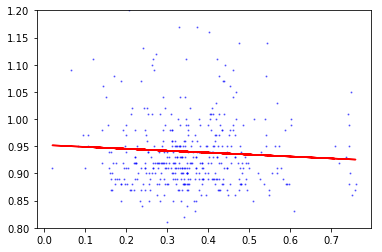

                adjusted_MLR  market_avg_pen
adjusted_MLR        1.000000       -0.058534
market_avg_pen     -0.058534        1.000000


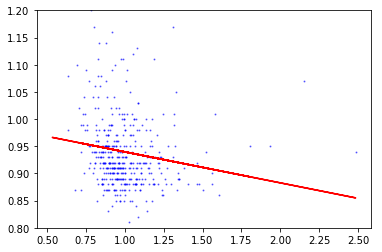

              adjusted_MLR  risk_score
adjusted_MLR      1.000000   -0.146027
risk_score       -0.146027    1.000000


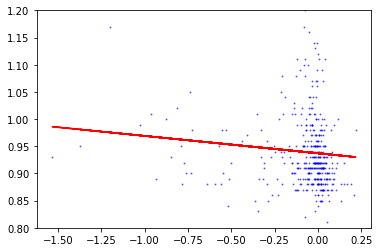

                 adjusted_MLR  risk_score_diff
adjusted_MLR         1.000000        -0.090442
risk_score_diff     -0.090442         1.000000


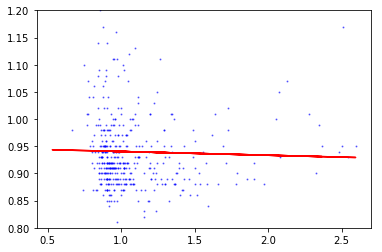

                   adjusted_MLR  market_risk_score
adjusted_MLR           1.000000          -0.028485
market_risk_score     -0.028485           1.000000


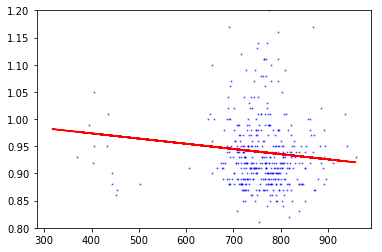

                    adjusted_MLR  market_avg_payment
adjusted_MLR             1.00000            -0.10077
market_avg_payment      -0.10077             1.00000


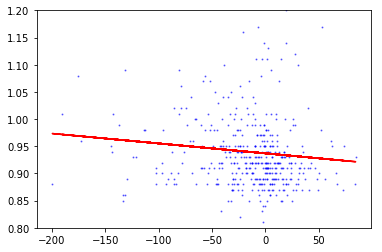

              adjusted_MLR  payment_diff
adjusted_MLR      1.000000     -0.100239
payment_diff     -0.100239      1.000000
                             contract_year  adjusted_MLR  risk_score  \
contract_year                          NaN           NaN         NaN   
adjusted_MLR                           NaN      1.000000   -0.146027   
risk_score                             NaN     -0.146027    1.000000   
avg_payment                            NaN     -0.144339   -0.031153   
total_enrollment                       NaN     -0.019495    0.016485   
market_risk_score                      NaN     -0.028485    0.737005   
market_avg_payment                     NaN     -0.100770   -0.024937   
market_avg_pen                         NaN     -0.058534    0.254847   
STARS_stayinghealth                    NaN      0.063284   -0.131116   
STARS_managingchronic                  NaN      0.060611   -0.025281   
STARS_experience                       NaN      0.063446   -0.216687   
STARS_compain

In [5]:
print df_MLR.describe()

#Graph Penetration Rate x MLR             
x = df_MLR['market_avg_pen']
y = df_MLR['adjusted_MLR']
fig, ax = plt.subplots()
fit = np.polyfit(x, y, deg=1)
ax.plot(x, fit[0] * x + fit[1], color='red')
ax.scatter(x, y, s=1, c='blue', alpha=0.5)
plt.ylim([0.80,1.20])
plt.show()

print df_MLR[['adjusted_MLR', 'market_avg_pen']].corr()

#Graph Risk Score x MLR             
x = df_MLR['risk_score']
y = df_MLR['adjusted_MLR']
fig, ax = plt.subplots()
fit = np.polyfit(x, y, deg=1)
ax.plot(x, fit[0] * x + fit[1], color='red')
ax.scatter(x, y, s=1, c='blue', alpha=0.5)
plt.ylim([0.80,1.20])
plt.show()

print df_MLR[['adjusted_MLR', 'risk_score']].corr()
#Somewhat of a correlation, let me try to look at the difference between the risk score and market avg
df_MLR['risk_score_diff'] = df_MLR['risk_score'] - df_MLR['market_risk_score']

#Graph Risk Score Diff x MLR             
x = df_MLR['risk_score_diff']
y = df_MLR['adjusted_MLR']
fig, ax = plt.subplots()
fit = np.polyfit(x, y, deg=1)
ax.plot(x, fit[0] * x + fit[1], color='red')
ax.scatter(x, y, s=1, c='blue', alpha=0.5)
plt.ylim([0.80,1.20])
plt.show()

print df_MLR[['adjusted_MLR', 'risk_score_diff']].corr()

#Graph Market Risk Score x MLR             
x = df_MLR['market_risk_score']
y = df_MLR['adjusted_MLR']
fig, ax = plt.subplots()
fit = np.polyfit(x, y, deg=1)
ax.plot(x, fit[0] * x + fit[1], color='red')
ax.scatter(x, y, s=1, c='blue', alpha=0.5)
plt.ylim([0.80,1.20])
plt.show()

print df_MLR[['adjusted_MLR', 'market_risk_score']].corr()

#Graph Market Avg. Payment x MLR  
x = df_MLR['market_avg_payment']
y = df_MLR['adjusted_MLR']
fig, ax = plt.subplots()
fit = np.polyfit(x, y, deg=1)
ax.plot(x, fit[0] * x + fit[1], color='red')
ax.scatter(x, y, s=1, c='blue', alpha=0.5)
plt.ylim([0.80,1.20])
plt.show()

print df_MLR[['adjusted_MLR', 'market_avg_payment']].corr()

#Somewhat of a correlation, let me try to look at the difference between the market avg pymt and market avg
df_MLR['payment_diff'] = df_MLR['avg_payment'] - df_MLR['market_avg_payment']

#Graph Payment Diff x MLR  
x = df_MLR['payment_diff']
y = df_MLR['adjusted_MLR']
fig, ax = plt.subplots()
fit = np.polyfit(x, y, deg=1)
ax.plot(x, fit[0] * x + fit[1], color='red')
ax.scatter(x, y, s=1, c='blue', alpha=0.5)
plt.ylim([0.80,1.20])
plt.show()

print df_MLR[['adjusted_MLR', 'payment_diff']].corr()

#Look at Correlation Matrix to help in feature selection
print df_MLR.corr()

Biggest Takeaway:<br>
MLR seems to have a fairly wide distribution.  While there are some strong moderate correlations, nothing appears definitive.
<br> <br>


Section 4 - Modeling

In [9]:
print 'Random Forest:'
from sklearn.ensemble import RandomForestClassifier

predictors = ['risk_score', 'avg_payment', 'market_avg_pen', 'is_Blue', 'is_National', 'is_HMO',\
              'is_Local PPO', 'is_MSA', 'is_PFFS', 'is_STARS_2.5', 'is_STARS_3.0', 'is_STARS_3.5',\
              'is_STARS_4.0', 'is_STARS_4.5','is_STARS_5.0']
X = df_MLR[predictors]
y= df_MLR['is_profitable']

model = RandomForestClassifier(n_estimators = 85) 
model.fit(X, y)

features = predictors
feature_importances = model.feature_importances_

features_df = pd.DataFrame({'Features': features, 'Importance Score': feature_importances})
features_df.sort_values('Importance Score', inplace=True, ascending=False)
print 'Feature Importance Scores:'
print features_df

from sklearn import cross_validation
kfold = cross_validation.KFold(len(X), n_folds=5)
scores = cross_validation.cross_val_score(model, X, y, cv=kfold,scoring='roc_auc')
print 'Average AUC: %f' % scores.mean()
scores = cross_validation.cross_val_score(model, X, y, cv=kfold,scoring='accuracy')
print 'Average Accuracy: %f' % scores.mean()
scores = cross_validation.cross_val_score(model, X, y, cv=kfold,scoring='average_precision')
print 'Average Precision: %f' % scores.mean()

print ''
print ''


print 'Linear Regression:'
from sklearn.linear_model import LinearRegression

predictors = ['risk_score', 'avg_payment', 'market_avg_pen', 'is_Blue', 'is_National', 'is_HMO',\
              'is_Local PPO', 'is_MSA', 'is_PFFS', 'is_STARS_2.5', 'is_STARS_3.0', 'is_STARS_3.5',\
              'is_STARS_4.0', 'is_STARS_4.5','is_STARS_5.0']
X = df_MLR[predictors]
y= df_MLR['adjusted_MLR']
model = LinearRegression()
model.fit(X, y)
feature_set = df_MLR[predictors]
print 'R^2:'
print model.score(X,y)

print 'Feature Coefficients:'
print zip(feature_set,model.coef_)

scores = cross_validation.cross_val_score(model, X, y, cv=kfold,scoring='neg_mean_squared_error')
print 'Average MSE: %f' % scores.mean()





print ''
print ''
print 'Logistics Regression:'
from sklearn.linear_model import LogisticRegression

predictors = ['risk_score', 'avg_payment', 'market_avg_pen', 'is_Blue', 'is_National', 'is_HMO',\
              'is_Local PPO', 'is_MSA', 'is_PFFS', 'is_STARS_2.5', 'is_STARS_3.0', 'is_STARS_3.5',\
              'is_STARS_4.0', 'is_STARS_4.5','is_STARS_5.0']
X = df_MLR[predictors]
y= df_MLR['is_profitable']
model = LogisticRegression()
model.fit(X, y)
feature_set = df_MLR[predictors]
print 'R^2:'
print model.score(X,y)
print 'Feature Coefficients:'
print zip(feature_set,np.exp(model.coef_)[0])

scores = cross_validation.cross_val_score(model, X, y, cv=kfold,scoring='roc_auc')
print 'Average AUC: %f' % scores.mean()
scores = cross_validation.cross_val_score(model, X, y, cv=kfold,scoring='accuracy')
print 'Average Accuracy: %f' % scores.mean()
scores = cross_validation.cross_val_score(model, X, y, cv=kfold,scoring='average_precision')
print 'Average Precision: %f' % scores.mean()

Random Forest:
Feature Importance Scores:
          Features  Importance Score
1      avg_payment          0.254911
2   market_avg_pen          0.254134
0       risk_score          0.252677
4      is_National          0.052468
11    is_STARS_3.5          0.031586
10    is_STARS_3.0          0.024364
12    is_STARS_4.0          0.022681
14    is_STARS_5.0          0.020859
13    is_STARS_4.5          0.019789
3          is_Blue          0.017992
5           is_HMO          0.017801
6     is_Local PPO          0.016533
9     is_STARS_2.5          0.005873
8          is_PFFS          0.005274
7           is_MSA          0.003058
Average AUC: 0.767210
Average Accuracy: 0.851578
Average Precision: 0.946108


Linear Regression:
R^2:
0.281156203726
Feature Coefficients:
[('risk_score', -0.0090133676071455331), ('avg_payment', -9.2741732888524525e-05), ('market_avg_pen', -0.062209703097941917), ('is_Blue', -0.013707982886921641), ('is_National', -0.045204946905767214), ('is_HMO', 0.02160557865

Section 5: Presentation Visualizations

In [16]:
df_MLR_full = df_MLR.dropna()

from sklearn import preprocessing
import plotly.graph_objs as go
from scipy import stats
import json


# 5.1 Scatterplot MLR vs. STARS
X = df_MLR_full['STARS_Overall']
Y = df_MLR_full['adjusted_MLR']

slope, intercept, r_value, p_value, std_err = stats.linregress(X,Y)
line = slope*X+intercept

# Create a trace
trace = go.Scatter(
    x = X,
    y = Y,
    mode = 'markers',
    name = 'data'
)
trace2 = go.Scatter(
                  x=X, 
                  y=line, 
                  mode='lines',
                  marker=go.Marker(color='rgb(31, 119, 180)'),
                  name='Fit'
                  )
layout = go.Layout(
                title='Figure 1: STARS vs. MLR',
                plot_bgcolor='rgb(229, 229, 229)',
                  xaxis=go.XAxis(zerolinecolor='rgb(255,255,255)', gridcolor='rgb(255,255,255)'),
                  yaxis=go.YAxis(zerolinecolor='rgb(255,255,255)', gridcolor='rgb(255,255,255)')
                )

data = [trace, trace2]
fig = go.Figure(data=data, layout=layout)

iplot(fig)

# 5.2 Create County File for analysis
df_statelist = pd.read_csv("/Users/cventura/GitHub/final_project/final_datasets/state_geo/states_list.csv")

df_county_geo = pd.DataFrame()

for state in df_statelist['state_name']:
    file = '/Users/cventura/GitHub/final_project/final_datasets/state_geo/' + state + '.geojson'
    with open(file) as f:
        counties = json.load(f)
    df_state = df_countypen[df_countypen['State Name'] == state]
    geo_dict = {}
    for x in range(len(counties['features'])):
        # I ignore the last eleven characters in the name since the geojson file includes ' County, CO' in the county names and the population data does not
        name = counties['features'][x]['properties']['name'][:-11]
        geo_dict[name] = counties['features'][x]   
    ser = pd.Series(geo_dict.values(), index = geo_dict.keys())
    ser.name = 'coordinates'
    df_state = df_state.join(ser, on='County Name')
    df_county_geo = df_county_geo.append(df_state)

colors = ['#ffffe0','#fffddb','#fffad7','#fff7d1','#fff5cd','#fff2c8',
          '#fff0c4','#ffedbf','#ffebba','#ffe9b7','#ffe5b2','#ffe3af',
          '#ffe0ab','#ffdda7','#ffdba4','#ffd9a0','#ffd69c','#ffd399',
          '#ffd196','#ffcd93','#ffca90','#ffc88d','#ffc58a','#ffc288',
          '#ffbf86','#ffbd83','#ffb981','#ffb67f','#ffb47d','#ffb17b',
          '#ffad79','#ffaa77','#ffa775','#ffa474','#ffa172','#ff9e70',
          '#ff9b6f','#ff986e','#ff956c','#fe916b','#fe8f6a','#fd8b69',
          '#fc8868','#fb8567','#fa8266','#f98065','#f87d64','#f77a63',
          '#f67862','#f57562','#f37261','#f37060','#f16c5f','#f0695e',
          '#ee665d','#ed645c','#ec615b','#ea5e5b','#e85b59','#e75859',
          '#e55658','#e45356','#e35056','#e14d54','#df4a53','#dd4852',
          '#db4551','#d9434f','#d8404e','#d53d4d','#d43b4b','#d2384a',
          '#cf3548','#cd3346','#cc3045','#ca2e43','#c72b42','#c52940',
          '#c2263d','#c0233c','#be213a','#bb1e37','#ba1c35','#b71933',
          '#b41731','#b2152e','#b0122c','#ac1029','#aa0e27','#a70b24',
          '#a40921','#a2071f','#a0051c','#9d0419','#990215','#970212',
          '#94010e','#91000a','#8e0006','#8b0000', '#8b0000']

scl = dict(zip(range(0, 101), colors))

def get_scl(obj):
    frac = obj* 100
    frac = round(frac,0)
    return scl[frac]


# 5.2 Additional Fields for mappings

df_plancounty_countyCRS['enrollmentxRS'] = df_plancounty_countyCRS['county_enrollment'] * df_plancounty_countyCRS['rs_nonSNP'] 
df_plancounty_countyCRS['enrollmentxpymt'] = df_plancounty_countyCRS['county_enrollment'] * df_plancounty_countyCRS['avg_pymt_nonSNP'] 

df_countyRSpymtStats =  df_plancounty_countyCRS.groupby(['county_code'])[['county_enrollment', 'enrollmentxRS', 'enrollmentxpymt']].sum(
        ).reset_index()

df_countyRSpymtStats['avg_RS'] = df_countyRSpymtStats['enrollmentxRS'] / df_countyRSpymtStats['county_enrollment']
df_countyRSpymtStats['avg_pymt'] = df_countyRSpymtStats['enrollmentxpymt'] / df_countyRSpymtStats['county_enrollment']

df_county_geo = df_county_geo.merge(df_countyRSpymtStats, how= 'left', left_on='SSA', right_on='county_code')  
             
df_county_geo_full = df_county_geo.dropna()
df_county_geo_full = df_county_geo_full[df_county_geo_full['avg_RS'] != 0.0]

min_max_scaler = preprocessing.MinMaxScaler()

df_county_geo_full['norm_RS'] = min_max_scaler.fit_transform(df_county_geo_full['avg_RS'])
df_county_geo_full['norm_pymt'] = min_max_scaler.fit_transform(df_county_geo_full['avg_pymt'])

df_county_geo['color'] = df_county_geo['Penetration'].apply(get_scl)
df_county_geo_full['color_2'] = df_county_geo_full['norm_RS'].apply(get_scl)
df_county_geo_full['color_3'] = df_county_geo_full['norm_pymt'].apply(get_scl)




/Users/cventura/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

/Users/cventura/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

/Users/cventura/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

/Users/cventura/ana

Mapping Code:

#Penetration Rate by County

layers_ls = []
for x in df_county_geo.index:
    item_dict = dict(sourcetype = 'geojson',
                     source = df_county_geo.ix[x]['coordinates'],
                     type = 'fill',
                     color = df_county_geo.ix[x]['color'])
    layers_ls.append(item_dict)
    
mapbox_access_token = 'pk.eyJ1IjoiY3ZlbnR1cmEiLCJhIjoiY2oycGZpazdiMDM5NzJybWkwYTFwdHNzdiJ9.896qwC2f74zfjA7DgbGvWA'
colorscl = [[i * .01, v] for i,v in enumerate(colors)]
data = go.Data([
            go.Scattermapbox(
                    lat = [0],
                    lon = [0],                   
                    marker = go.Marker(
                                  cmax=100,
                                  cmin=0,
                                  colorscale = colorscl,
                                  showscale = True,
                                  autocolorscale=False,
                                  color=range(0,101),
                                  colorbar= go.ColorBar(
                                                 len = .89
                                                        )
                                       ),
                    mode = 'markers')
                     ])
layout = go.Layout(
    title = 'MA Penetration Rate by County',
    height=800,
    width=1000,
    autosize=True,
    hovermode='closest',
    mapbox=dict(
        layers= layers_ls,
        accesstoken=mapbox_access_token,
        bearing=0,
        center=dict(
            lat=39.50,
            lon=-98.35
        ),
        pitch=0,
        zoom=3.0,
        style='light'
    ),
)

fig = dict(data = data, layout=layout)
plot (fig, filename='/Users/cventura/GitHub/final_project/US_Map.html')

#Risk Score by County

layers_ls = []
for x in df_county_geo_full.index:
    item_dict = dict(sourcetype = 'geojson',
                     source = df_county_geo_full.ix[x]['coordinates'],
                     type = 'fill',
                     color = df_county_geo_full.ix[x]['color_2'])
    layers_ls.append(item_dict)
    
mapbox_access_token = 'pk.eyJ1IjoiY3ZlbnR1cmEiLCJhIjoiY2oycGZpazdiMDM5NzJybWkwYTFwdHNzdiJ9.896qwC2f74zfjA7DgbGvWA'
colorscl = [[i * .01, v] for i,v in enumerate(colors)]
data = go.Data([
            go.Scattermapbox(
                    lat = [0],
                    lon = [0],                   
                    marker = go.Marker(
                                  cmax=100,
                                  cmin=0,
                                  colorscale = colorscl,
                                  showscale = True,
                                  autocolorscale=False,
                                  color=range(0,101),
                                  colorbar= go.ColorBar(
                                                 len = .89
                                                        )
                                       ),
                    mode = 'markers')
                     ])
layout = go.Layout(
    title = 'MA Risk Score by County',
    height=800,
    width=1000,
    autosize=True,
    hovermode='closest',
    mapbox=dict(
        layers= layers_ls,
        accesstoken=mapbox_access_token,
        bearing=0,
        center=dict(
            lat=39.50,
            lon=-98.35
        ),
        pitch=0,
        zoom=3.0,
        style='light'
    ),
)

fig = dict(data = data, layout=layout)
plot (fig, filename='/Users/cventura/GitHub/final_project/US_RS_Map.html')

#Payment by County

layers_ls = []
for x in df_county_geo_full.index:
    item_dict = dict(sourcetype = 'geojson',
                     source = df_county_geo_full.ix[x]['coordinates'],
                     type = 'fill',
                     color = df_county_geo_full.ix[x]['color_3'])
    layers_ls.append(item_dict)
    
mapbox_access_token = 'pk.eyJ1IjoiY3ZlbnR1cmEiLCJhIjoiY2oycGZpazdiMDM5NzJybWkwYTFwdHNzdiJ9.896qwC2f74zfjA7DgbGvWA'
colorscl = [[i * .01, v] for i,v in enumerate(colors)]
data = go.Data([
            go.Scattermapbox(
                    lat = [0],
                    lon = [0],                   
                    marker = go.Marker(
                                  cmax=100,
                                  cmin=0,
                                  colorscale = colorscl,
                                  showscale = True,
                                  autocolorscale=False,
                                  color=range(0,101),
                                  colorbar= go.ColorBar(
                                                 len = .89
                                                        )
                                       ),
                    mode = 'markers')
                     ])
layout = go.Layout(
    title = 'MA Avg Payment by County',
    height=800,
    width=1000,
    autosize=True,
    hovermode='closest',
    mapbox=dict(
        layers= layers_ls,
        accesstoken=mapbox_access_token,
        bearing=0,
        center=dict(
            lat=39.50,
            lon=-98.35
        ),
        pitch=0,
        zoom=3.0,
        style='light'
    ),
)

fig = dict(data = data, layout=layout)
plot (fig, filename='/Users/cventura/GitHub/final_project/US_Pymt_Map.html')

